In [1]:
# Modules
import numpy as np
import xarray as xr
import pandas as pd

from data import data_loader
from data import gesla_preprocessing
from data import era5_preprocessing
from data import preprocessing

In [2]:
# ---
# Preprocessing
# ---

# Get timeseries of predictor and predictand
percentile = 0.95
predictor = "sp"
season = "winter"

X, Y, t = preprocessing.preprocessing1(season, predictor, percentile)

# Handle NaN values: 
# Insert numerical value that is not in data.
# ML will hopefully recognize it.
X[np.where(np.isnan(X))] = -999

# Save number of lat/lon for interpreting model output later
ndim = X.shape[0]
nlat = X.shape[1]
nlon = X.shape[2]

# Prepare shape for model
X = X.reshape(ndim, -1) # (ndim, nclasses)
y = Y[:, 0] # Select only one station

Load ERA5-Predictor: sp in region: lon-0530_lat7040 for years: 1999-2008 in season: winter
Load Predictand from GESLA
Applied one-hot-encoding
Get overlapping timeseries of ERA5 and GESLA


In [18]:
#---
# Train Model
#---
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25)

# Setup Model

model = RandomForestClassifier(criterion='gini',
n_estimators=91, #- nTrees 
max_depth=9, 
random_state=0, # To compare results when changing hyperparameters
class_weight="balanced",
oob_score=True,
)

model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=91,
                       oob_score=True, random_state=0)

In [19]:
#---
# Evaluate model / Diagnostic
#--- 
# Score & Importance
test_score = model.score(X_test, y_test)
train_score = model.score(X_train, y_train)
importances = model.feature_importances_

print(f"test_score: {test_score}")
print(f"train_score: {train_score}")
print(f"importances: {importances}")

test_score: 0.8982300884955752
train_score: 0.9556868537666174
importances: [0.00000000e+00 1.72891519e-04 2.81572627e-20 ... 4.34961487e-04
 0.00000000e+00 0.00000000e+00]
True values at index of false prediction:
 [1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0.]


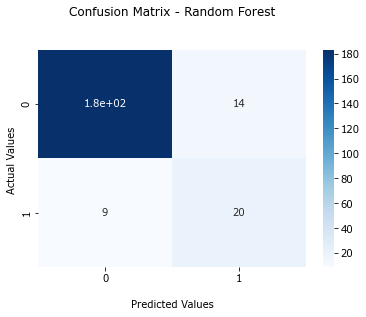

In [39]:
%matplotlib inline
#---
#  Diagnostics
#---

# Confusion matrix
#---
# Format: 
# Reality / Model: Negative, Positive
# Negative    Right Negative, False Positive 
# Positive    False Negative, Right Positive

from sklearn.metrics import confusion_matrix

y_test_pred = model.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_test_pred)

# Plot Confusion Matrix
#---
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix - Random Forest\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

## Display the visualization of the Confusion Matrix.
plt.show()


AUC: 0.8767722737615964


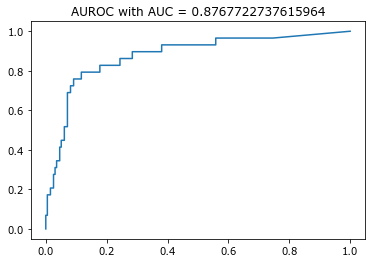

In [41]:
# AUROC
# Receiver Operating Characteristics & Area Under the Curve
#---
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_test_proba = model.predict_proba(X_test)[:, 1] # Prob. for predicting 0 or 1, we only need second col

fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
auc = roc_auc_score(y_test, y_test_proba)

print(f'AUC: {auc}')
fig, ax = plt.subplot
plt.plot(fpr, tpr)
plt.title(f"AUROC with AUC = {auc}")
plt.show()

In [16]:
#---
# Optimization: Hyperparameters
#---

# Build Pipeline
#---
from sklearn.pipeline import Pipeline

max_depth = 9

pipeline = Pipeline([
    ("rf", RandomForestClassifier(criterion='gini',
n_estimators=91, #- nTrees 
max_depth=max_depth, 
random_state=0, # To compare results when changing hyperparameters
class_weight="balanced",
oob_score=True,)),
])

# pipeline.set_params(knn__n_neighbors = 1) # To change parameters

# Apply GridSearch
#---
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(pipeline, param_grid = {
    "rf__max_depth": np.arange(1, 10),
    "rf__n_estimators": np.arange(90, 100),
})

clf.fit(X_train, y_train)

# Display params
#---
print(clf.best_params_)

print(clf.score(X_test, y_test)) # Accuracy on basis of test data

print(clf.best_score_) # Accuracy based on k-fold cross-validation

{'rf__max_depth': 9, 'rf__n_estimators': 91}
0.8982300884955752
0.8404793028322441


In [ ]:
# Postprocessing

In [ ]:
# Visualization